In [78]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization,Activation, MaxPool2D, Concatenate

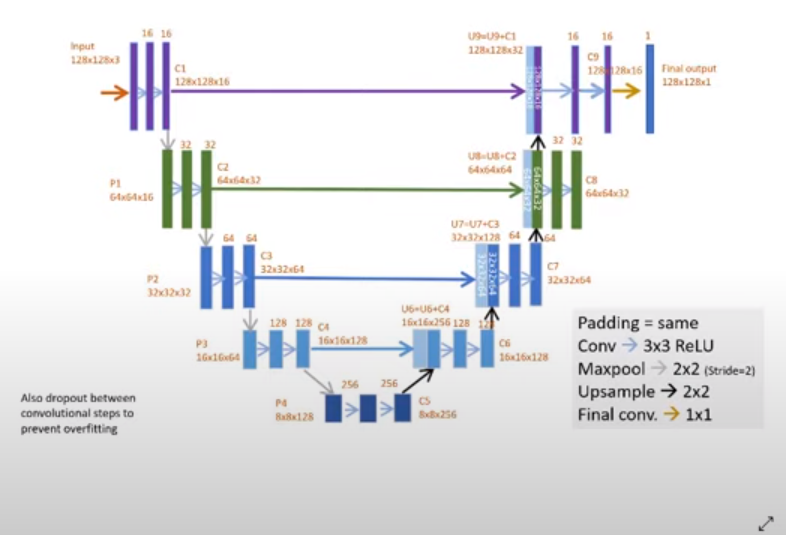

In [81]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p


def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x


def build_unet(input_shape, n_classes):
    inputs = tf.keras.layers.Input(shape=input_shape)
    c1, p1 = encoder_block(inputs, 16)
    c2, p2 = encoder_block(p1, 32)
    c3, p3 = encoder_block(p2, 64)
    c4, p4 = encoder_block(p3, 128)

    c5 = conv_block(p4, 256) #Bridge
    c6 = decoder_block(c5, c4, 128)
    c7 = decoder_block(c6, c3, 64)
    c8 = decoder_block(c7, c2, 32)
    c9 = decoder_block(c8, c1, 16)

    if n_classes == 1:  #Binary
        activation = 'sigmoid'
    else:
        activation = 'softmax'
    
    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(c9)
    model = Model(inputs, outputs, name="U-Net")
    return model

In [2]:
# def conv_block(input, num_filters):
#     x = Conv2D(num_filters, 3, padding="same")(input)
#     x = BatchNormalization()(x)
#     x = Activation("relu")(x)

#     x = Conv2D(num_filters, 3, padding="same")(x)
#     x = BatchNormalization()(x)
#     x = Activation("relu")(x)

#     return x


# def encoder_block(input, num_filters):
#     x = conv_block(input, num_filters)
#     p = MaxPool2D((2, 2))(x)
#     return x, p


# def decoder_block(input, skip_features, num_filters):
#     x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
#     x = Concatenate()([x, skip_features])
#     x = conv_block(x, num_filters)
#     return x


# def build_unet(input_shape, n_classes):
#     inputs = tf.keras.layers.Input(shape=input_shape)
#     s1, p1 = encoder_block(inputs, 32)
#     s2, p2 = encoder_block(p1, 64)
#     s3, p3 = encoder_block(p2, 128)

#     b1 = conv_block(p3, 512) #Bridge
#     d2 = decoder_block(b1, s3, 128)
#     d3 = decoder_block(d2, s2, 64)
#     d4 = decoder_block(d3, s1, 32)

#     if n_classes == 1:  #Binary
#         activation = 'sigmoid'
#     else:
#         activation = 'softmax'

#     outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)
#     model = Model(inputs, outputs, name="U-Net")
#     return model

In [82]:
model = build_unet((128,128,3), 1)
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 128, 128, 16) 448         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_26 (BatchNo (None, 128, 128, 16) 64          conv2d_27[0][0]                  
__________________________________________________________________________________________________
activation_26 (Activation)      (None, 128, 128, 16) 0           batch_normalization_26[0][0]     
______________________________________________________________________________________________

In [83]:
import re
import os 
import glob 

class DataReader(object):
    def __init__(self, img_dir, label_dir, img_size):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.imgs_path = glob.glob(f"{self.img_dir}/*.jpg")
        self.num_imgs = len(self.imgs_path)
        self.width, self.height = img_size
    
    def __len__(self):
        return self.num_imgs
    
    
    def resize_crop_pad(self, img, is_label=False):
        """
        img -> PIL.Image
        return -> PIL.Image
        """
        target_width, target_height = self.width, self.height
        original_width, original_height = img.size
        original_aspect_ratio = original_width / original_height
        target_aspect_ratio = target_width / target_height
        if original_aspect_ratio > target_aspect_ratio:
            scale_factor = target_width / original_width
        else:
            scale_factor = target_height / original_height

        resized_image = img.resize((int(original_width * scale_factor), int(original_height * scale_factor)), Image.BILINEAR)
        if is_label:
            padded_image = Image.new("L", (target_width, target_height))
        else:
            padded_image = Image.new("RGB", (target_width, target_height), color=(0, 0, 0))
        paste_x = (target_width - resized_image.width) // 2
        paste_y = (target_height - resized_image.height) // 2
        padded_image.paste(resized_image, (paste_x, paste_y))

        return padded_image
    
    def binarize_image(self, img):
        """
        image -> PIL.Image
        return -> PIL.Image
        """
        img = img.convert("L")
        img_array = np.array(img)
        binary_img_array = np.where(img_array > 0, 1, 0)
        binary_img = Image.fromarray(binary_img_array.astype(np.uint8), mode="L")
        return binary_img
    
    
    def find_label(self, img_path):
        label_path = re.sub(self.img_dir, self.label_dir, img_path)
        label_path = re.sub(".jpg", ".png", label_path)
        return label_path if os.path.exists(label_path) else None
    
    
    def __getitem__(self, index):
        img_path = self.imgs_path[index]
        label_path = self.find_label(img_path)
        img = Image.open(img_path)
        img = self.resize_crop_pad(img)
        label = Image.open(label_path)
        label = self.resize_crop_pad(label, is_label=True)
        label = self.binarize_image(label)
        img_np = np.array(img) / 255.
        label_np = np.expand_dims(np.array(label), -1)
        return img_np, label_np        
    
    def iter(self):
        for i in range(self.num_imgs):
            yield self[i]

In [84]:
batch_size = 4
img_dir = "/app/seg/data/images/train/"
label_dir = "/app/seg/data/labels/train/"
data_reader = DataReader(img_dir, label_dir, img_size=(128, 128))
dataset = tf.data.Dataset.from_generator(data_reader.iter,
                                         output_types=(tf.float32, tf.float32),
                                         output_shapes=([128, 128, 3], [128, 128, 1]))
dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [85]:
def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coefficient(y_true, y_pred)
    return loss

In [86]:
metrics = tf.keras.metrics.MeanIoU(num_classes=2)

In [141]:
from tensorflow.keras.optimizers import Adam
from PIL import Image 
import numpy as np

# model.compile(optimizer=Adam(learning_rate=1e-3), loss=dice_loss, metrics=['accuracy'])
model.compile(optimizer=Adam(learning_rate=1e-3), loss="binary_crossentropy", metrics=metrics)

history = model.fit(dataset,
                    epochs=50)

Epoch 1/50
129/129 [==============================] - 3s 22ms/step - loss: 0.0840 - mean_io_u_1: 0.8620
Epoch 2/50
129/129 [==============================] - 3s 22ms/step - loss: 0.0357 - mean_io_u_1: 0.8216
Epoch 3/50
129/129 [==============================] - 3s 22ms/step - loss: 0.0294 - mean_io_u_1: 0.8219
Epoch 4/50
129/129 [==============================] - 3s 22ms/step - loss: 0.0264 - mean_io_u_1: 0.8149
Epoch 5/50
129/129 [==============================] - 3s 23ms/step - loss: 0.0242 - mean_io_u_1: 0.8156
Epoch 6/50
129/129 [==============================] - 3s 21ms/step - loss: 0.0234 - mean_io_u_1: 0.8121
Epoch 7/50
129/129 [==============================] - 3s 22ms/step - loss: 0.0232 - mean_io_u_1: 0.8069
Epoch 8/50
129/129 [==============================] - 3s 22ms/step - loss: 0.0238 - mean_io_u_1: 0.7970
Epoch 9/50
129/129 [==============================] - 3s 22ms/step - loss: 0.0260 - mean_io_u_1: 0.7807
Epoch 10/50
129/129 [==============================] - 3s 22ms/s

In [195]:
def resize_crop_pad(img, is_label=False):
    """
    img -> PIL.Image
    return -> PIL.Image
    """
    target_width, target_height = 128, 128
    original_width, original_height = img.size
    original_aspect_ratio = original_width / original_height
    target_aspect_ratio = target_width / target_height
    if original_aspect_ratio > target_aspect_ratio:
        scale_factor = target_width / original_width
    else:
        scale_factor = target_height / original_height

    resized_image = img.resize((int(original_width * scale_factor), int(original_height * scale_factor)), Image.BILINEAR)
    if is_label:
        padded_image = Image.new("L", (target_width, target_height))
    else:
        padded_image = Image.new("RGB", (target_width, target_height), color=(0, 0, 0))
    paste_x = (target_width - resized_image.width) // 2
    paste_y = (target_height - resized_image.height) // 2
    padded_image.paste(resized_image, (paste_x, paste_y))

    return padded_image

In [142]:
img_dir = "/app/seg/data/images/test/"
label_dir = "/app/seg/data/labels/test/"
data_reader = DataReader(img_dir, label_dir, img_size=(128, 128))
test_dataset = tf.data.Dataset.from_generator(data_reader.iter,
                                         output_types=(tf.float32, tf.float32),
                                         output_shapes=([128, 128, 3], [128, 128, 1]))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
model.evaluate(test_dataset)

17/17 [==============================] - 0s 12ms/step - loss: 0.6286 - mean_io_u_1: 0.4513


[0.628601610660553, 0.45129743218421936]

In [143]:
for x,y in test_dataset:
    img = x[0]
    print(img.shape)
    np_array = np.array(img) * 255
    img_p = Image.fromarray(np_array.astype(np.uint8))
    img_p.show()
    label = y[0]
    print(label.shape)
    label_array = np.squeeze(np.array(label)) * 255
    label_p = Image.fromarray(label_array.astype(np.uint8), "L")
    label_p.show()
    break

(128, 128, 3)
(128, 128, 1)


In [144]:
def resize_crop_pad(img, is_label=False):
    """
    img -> PIL.Image
    return -> PIL.Image
    """
    target_width, target_height = 128, 128
    original_width, original_height = img.size
    original_aspect_ratio = original_width / original_height
    target_aspect_ratio = target_width / target_height
    if original_aspect_ratio > target_aspect_ratio:
        scale_factor = target_width / original_width
    else:
        scale_factor = target_height / original_height

    resized_image = img.resize((int(original_width * scale_factor), int(original_height * scale_factor)), Image.BILINEAR)
    if is_label:
        padded_image = Image.new("L", (target_width, target_height))
    else:
        padded_image = Image.new("RGB", (target_width, target_height), color=(0, 0, 0))
    paste_x = (target_width - resized_image.width) // 2
    paste_y = (target_height - resized_image.height) // 2
    padded_image.paste(resized_image, (paste_x, paste_y))

    return padded_image

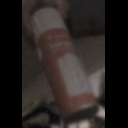

In [160]:
# test_img = "/app/seg/data/images/test/9300633320775_1708733394893_2_1708733432295_9626189.jpg"
# test_img = "/app/seg/data/images/test/9300633320775_1708733394893_0_1708733418187_9614769.jpg"
# test_img = "/app/seg/data/images/test/9300633320775_1708733394893_0_1708733430029_9626622.jpg"
# test_img = "/app/seg/data/images/test/9300633320775_1708733394893_1_1708733400006_9603497.jpg"
# test_img = "/app/seg/data/images/test/9300633320775_1708733394893_1_1708733424290_9627776.jpg"
test_img = "/app/seg/data/images/test/9300633320775_1708733394893_2_1708733405316_9599244.jpg"

test_img = Image.open(test_img)
test_img = resize_crop_pad(test_img)
test_img

In [161]:
test_img_np = np.array(test_img) / 255.
test_img_np = np.expand_dims(test_img_np, 0)
result = model(test_img_np)
output = np.squeeze(result.numpy()) * 255
# output = np.expand_dims(output, -1)
print(output.shape)
output_pil = Image.fromarray(output.astype(np.uint8), "L")

(128, 128)


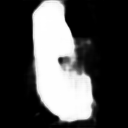

In [162]:
output_pil

In [94]:
def apply_single_channel_mask(image, mask):
    mask_3_channels = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
    masked_image = np.where(mask_3_channels, image, 0)
    return masked_image

In [95]:
def binarize_img_np(img_np):
    """
    img -> np.array
    return -> np.array
    """
    binary_img_array = np.where(img_np > 0, 1, 0)
    return binary_img_array.astype(np.uint8)

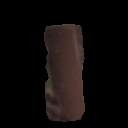

In [96]:
mask = binarize_img_np(np.array(output_pil))
masked_image = apply_single_channel_mask(np.array(test_img), mask)
masked_image_pil = Image.fromarray(masked_image)
masked_image_pil

In [75]:
def crop_masked_region(masked_image, mask):
    # Find bounding box of the mask
    non_zero_indices = np.argwhere(mask)
    min_y, min_x = np.min(non_zero_indices, axis=0)
    max_y, max_x = np.max(non_zero_indices, axis=0)

    # Crop out the region containing the mask
    cropped_masked_image = masked_image[min_y:max_y+1, min_x:max_x+1]

    return cropped_masked_image

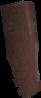

In [76]:
crop = crop_masked_region(masked_image, mask)
crop_pil = Image.fromarray(crop)
crop_pil

In [77]:
model.save("model.h5")